CS 422: Homework 4
Jaken Whipp

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

Reading the data from a CSV file

In [2]:
dataFrame = pd.read_csv('../input/us-zip-codes/uszips.csv')

Verifying the data has been properly read

In [3]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33788 entries, 0 to 33787
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   zip               33788 non-null  int64  
 1   lat               33788 non-null  float64
 2   lng               33788 non-null  float64
 3   city              33788 non-null  object 
 4   state_id          33788 non-null  object 
 5   state_name        33788 non-null  object 
 6   zcta              33788 non-null  bool   
 7   parent_zcta       0 non-null      float64
 8   population        32714 non-null  float64
 9   density           32714 non-null  float64
 10  county_fips       33788 non-null  int64  
 11  county_name       33788 non-null  object 
 12  county_weights    33788 non-null  object 
 13  county_names_all  33788 non-null  object 
 14  county_fips_all   33788 non-null  object 
 15  imprecise         33788 non-null  bool   
 16  military          33788 non-null  bool  

Removing columns which I do not for the assignment.
Statement to drop columns was found at this link: https://www.geeksforgeeks.org/how-to-drop-one-or-multiple-columns-in-pandas-dataframe/

In [4]:
dataFrame.drop(dataFrame.iloc[:, 6:18], inplace=True, axis=1)

Using value counts on state_name to find out what to remove during pre-processing. Based on the results Puerto Rico, Virgin Islands, Alaska, Hawaii, Guam, Northern Mariana Islands, and American Samoa should be removed from the dataset.

In [7]:
dataFrame.state_name.value_counts()

Texas                   1990
Pennsylvania            1833
New York                1826
California              1802
Illinois                1396
Ohio                    1233
Missouri                1035
Florida                 1011
Michigan                 992
Iowa                     970
Virginia                 903
Minnesota                881
North Carolina           853
Indiana                  807
Wisconsin                783
Kentucky                 780
Georgia                  751
West Virginia            738
Kansas                   704
Oklahoma                 664
Alabama                  656
Tennessee                636
Arkansas                 615
Washington               605
New Jersey               598
Nebraska                 586
Massachusetts            539
Louisiana                539
Colorado                 527
Maryland                 477
Oregon                   427
Mississippi              427
Maine                    426
South Carolina           424
Arizona       

In [8]:
dataFrame = dataFrame[dataFrame.state_name != "Puerto Rico"]
dataFrame = dataFrame[dataFrame.state_name != "Virgin Islands"]
dataFrame = dataFrame[dataFrame.state_name != "Alaska"]
dataFrame = dataFrame[dataFrame.state_name != "Hawaii"]
dataFrame = dataFrame[dataFrame.state_name != "Guam"]
dataFrame = dataFrame[dataFrame.state_name != "Northern Mariana Islands"]
dataFrame = dataFrame[dataFrame.state_name != "American Samoa"]

In [9]:
dataFrame.state_name.value_counts()

Texas                   1990
Pennsylvania            1833
New York                1826
California              1802
Illinois                1396
Ohio                    1233
Missouri                1035
Florida                 1011
Michigan                 992
Iowa                     970
Virginia                 903
Minnesota                881
North Carolina           853
Indiana                  807
Wisconsin                783
Kentucky                 780
Georgia                  751
West Virginia            738
Kansas                   704
Oklahoma                 664
Alabama                  656
Tennessee                636
Arkansas                 615
Washington               605
New Jersey               598
Nebraska                 586
Massachusetts            539
Louisiana                539
Colorado                 527
Maryland                 477
Oregon                   427
Mississippi              427
Maine                    426
South Carolina           424
Arizona       

Checking value counts of city variable

In [10]:
dataFrame.city.value_counts().head(10)

Houston        105
Washington      79
New York        69
Los Angeles     66
Miami           63
Kansas City     62
San Antonio     61
Dallas          59
Springfield     58
Chicago         56
Name: city, dtype: int64

Based purely on the value counts, which have the most zip codes, and should likely be the most dense, are Houston, Washington, New York, Los Angeles, Miami, Kansas City, San Antonio, Dallas, Springfield, and Chicago.

How to implement DBSCAN found here: https://www.kdnuggets.com/2022/08/implementing-dbscan-python.html

In [11]:
X_train = dataFrame[["zip", "lat", "lng"]]
clustering = DBSCAN(eps=12.5, min_samples=24).fit(X_train)
DBSCAN_dataset = X_train.copy()
DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_ 

Checking value counts of the clusters to make sure they are all not classified as outliers (-1). Based on some other min_samples values I tried, every item can be classified as an outlier so I went with 24 min samples which provides several clusters. (I also tried 25 which works but gives much less clusters. 22 also works but gives you around 700 clusters.)

In [12]:
DBSCAN_dataset.Cluster.value_counts().to_frame()

,Cluster
-1,30981
53,96
11,64
57,54
38,54
...,...
27,24
66,24
35,24
68,24


The plot1Data variable is created to hold information about the clusters which were not classed as outliers. This is done so the clusters can be visually represented.

In [13]:
plot1Data = DBSCAN_dataset[DBSCAN_dataset.Cluster != -1]

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


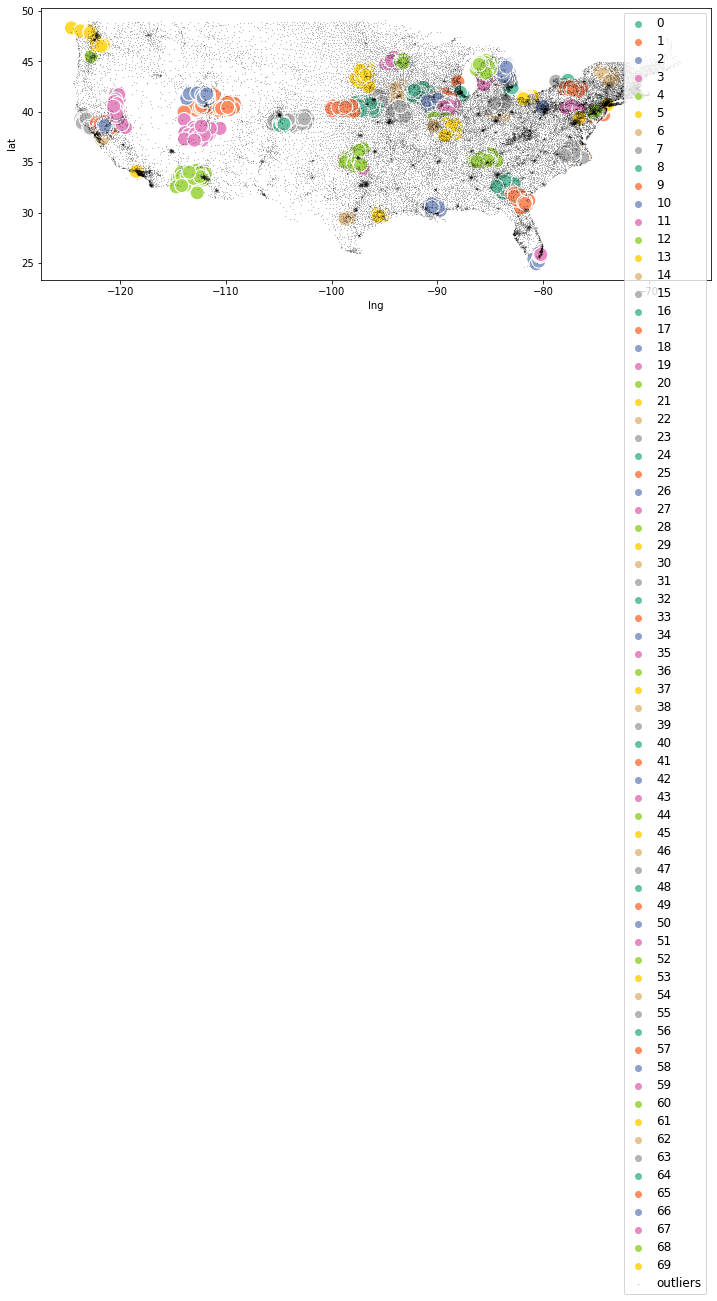

In [14]:
outliers = DBSCAN_dataset[DBSCAN_dataset['Cluster']==-1]

fig2, (axes) = plt.subplots(1,1,figsize=(12,5))

sns.scatterplot('lng', 'lat', data=plot1Data, hue='Cluster', ax=axes, palette='Set2', legend='full', s=200)

axes.scatter(outliers['lng'], outliers['lat'], s=0.01, label='outliers', c="k")

axes.legend()

plt.setp(axes.get_legend().get_texts(), fontsize='12')

plt.show()

The code in the next part of this notebook will look very disjointed. The purpose of this text box is to explain what is happening below and why it was done. Basically, I check what the 10 largest clusters are based on the model. Then, I take the information of all the rows which were grouped into that cluster. I can the use the zip codes from the grouped rows to find the city corresponding to that zip code. During this process, I noticed that several cities made up groupings. I could not run the DBSCAN algorithm using city as a parameter because it could not be converted to a float. As such, the approach I took was to put all the zip codes for the top 10 clusters into a list, then iterate through the list and use a dictionary to track counts of how often cities appear and then use the dictionary to determine the top 10 most common citites which were found in the clusters.

In [15]:
DBSCAN_dataset.Cluster.value_counts().to_frame().head(11)

,Cluster
-1,30981
53,96
11,64
57,54
38,54
29,54
22,50
21,49
36,49
59,48


Code to copy zip codes based on a cluster value found here: https://www.geeksforgeeks.org/different-ways-to-iterate-over-rows-in-pandas-dataframe/

In [16]:
zipCodeList = []

for ind in plot1Data.index:
    if(plot1Data['Cluster'][ind] == 53):
        zipCodeList.append(plot1Data['zip'][ind])
    if(plot1Data['Cluster'][ind] == 11):
        zipCodeList.append(plot1Data['zip'][ind])
    if(plot1Data['Cluster'][ind] == 57):
        zipCodeList.append(plot1Data['zip'][ind])
    if(plot1Data['Cluster'][ind] == 38):
        zipCodeList.append(plot1Data['zip'][ind])
    if(plot1Data['Cluster'][ind] == 29):
        zipCodeList.append(plot1Data['zip'][ind])
    if(plot1Data['Cluster'][ind] == 22):
        zipCodeList.append(plot1Data['zip'][ind])
    if(plot1Data['Cluster'][ind] == 21):
        zipCodeList.append(plot1Data['zip'][ind])
    if(plot1Data['Cluster'][ind] == 36):
        zipCodeList.append(plot1Data['zip'][ind])
    if(plot1Data['Cluster'][ind] == 59):
        zipCodeList.append(plot1Data['zip'][ind])
    if(plot1Data['Cluster'][ind] == 61):
        zipCodeList.append(plot1Data['zip'][ind])

How to copy city value from here: https://sparkbyexamples.com/pandas/pandas-extract-column-value-based-on-another-column/#:~:text=You%20can%20extract%20a%20column,column%20value%20matches%20with%2025000.

In [17]:
cityDict = {}

for i in range(len(zipCodeList)):
    curZip = zipCodeList[i]
    curCity = dataFrame[dataFrame['zip']==curZip]['city'].values[0]
    try:
        cityDict[curCity] += 1
    except KeyError:
        cityDict[curCity] = 1

How to sort dictionary found here: https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value

In [18]:
sortedCityDict = dict(sorted(cityDict.items(), key=lambda item: item[1]))

In [22]:
for key in sortedCityDict:
    curVal = sortedCityDict[key]
    print(key, curVal)

Cocolamus 1
Cornwall 1
Dalmatia 1
Dauphin 1
Dillsburg 1
Duncannon 1
East Waterford 1
Elizabethtown 1
Elizabethville 1
Elliottsburg 1
Enola 1
Fredericksburg 1
Grantham 1
Grantville 1
Granville 1
Gratz 1
Halifax 1
Hershey 1
Highspire 1
Honey Grove 1
Hummelstown 1
Ickesburg 1
Jonestown 1
Kleinfeltersville 1
Landisburg 1
Lawn 1
Lemoyne 1
Lewistown 1
Liverpool 1
Loysville 1
Lykens 1
McAlisterville 1
McVeytown 1
Mapleton Depot 1
Marysville 1
Mattawana 1
Mexico 1
Middletown 1
Mifflin 1
Mifflintown 1
Mill Creek 1
Millersburg 1
Millerstown 1
Milroy 1
Mount Gretna 1
Mount Holly Springs 1
Mount Union 1
Myerstown 1
New Bloomfield 1
New Buffalo 1
New Cumberland 1
New Germantown 1
Newmanstown 1
Newport 1
Newton Hamilton 1
Oakland Mills 1
Ono 1
Palmyra 1
Windsor 1
Lakewood 1
Rocky River 1
Beachwood 1
Independence 1
North Royalton 1
Maple Heights 1
Olmsted Falls 1
Solon 1
Bay Village 1
Brecksville 1
Brookpark 1
Westlake 1
Bedford 1
Broadview Heights 1
Anna 1
Ansonia 1
Arcanum 1
Bellbrook 1
Botkins 1
B

Based on my parameters and clustering method, the 10 largest cities are Houston, Minneapolis, Los Angeles, Cleveland, Joliet, Euclid, Cedar City, Orem, Layton, and Orland Park. While some of these results make sense, several do not. However, this was the results of my findings.

"I pledge I neither gave nor received unauthorized aid on this assignment."
-Jaken Whipp